In [7]:
# Import basic data science packages
import numpy as np

# Import tensorflow packages
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd /content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone

/content/drive/MyDrive/BrainStation Capstone Project/capstone


In [11]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

In [12]:
directory = '/content/drive/My Drive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = tfds.load("patch_camelyon", data_dir=directory, with_info=True, download=False)

ParseError: ignored

In [13]:
pcam, pcam_info = pcamlib.load_pcam()

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5RR3BS/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5RR3BS/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5RR3BS/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [14]:
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

In [15]:
vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))
# vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step


In [16]:
# Freeze all the layers in the base model
for layer in vgg16.layers:
    layer.trainable = False

In [18]:
# Add our own layers to the end of the network
x = vgg16.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

vgg16 = Model(inputs=vgg16.input, 
              outputs=output)

In [19]:
vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0   

In [20]:
# Changed from default 0.001
optimizer = Adam(learning_rate=0.01)

vgg16.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', 
                           verbose=1)

In [21]:
%%time
history = vgg16.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Epoch 1/30
4096/4096 [==============================] - 268s 60ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6936 - val_accuracy: 0.5005
Epoch 2/30
4096/4096 [==============================] - 244s 60ms/step - loss: 0.6934 - accuracy: 0.5008 - val_loss: 0.6936 - val_accuracy: 0.5005
Epoch 3/30
4096/4096 [==============================] - 237s 58ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5005
Epoch 4/30
4096/4096 [==============================] - 241s 59ms/step - loss: 0.6934 - accuracy: 0.5014 - val_loss: 0.6943 - val_accuracy: 0.5005
Epoch 5/30
4096/4096 [==============================] - 241s 59ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6936 - val_accuracy: 0.5005
Epoch 6/30
4096/4096 [==============================] - 242s 59ms/step - loss: 0.6934 - accuracy: 0.5007 - val_loss: 0.6937 - val_accuracy: 0.5005
Epoch 7/30
4096/4096 [==============================] - 241s 59ms/step - loss: 0.6934 - accuracy: 0.5006 - val_loss: 0

In [22]:
# Save the fitted model to a file
vgg16.save('data/models/vgg16')

INFO:tensorflow:Assets written to: data/models/vgg16/assets


INFO:tensorflow:Assets written to: data/models/vgg16/assets


In [23]:
# Save the history of the model to a csv
pcamlib.save_history(history, 'data/models/history/vgg16_history.csv')

In [24]:
# Uncomment the line below to load the model from file if necessary
# cnn = tf.keras.models.load_model("vgg16")
hist_df = pcamlib.load_history('data/models/history/vgg16_history.csv')

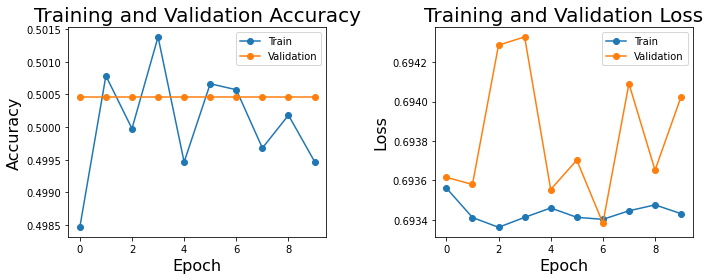

In [25]:
pcamlib.plot_history(hist_df)

In [26]:
%%time
pcamlib.print_test_accuracy(vgg16, test_pipeline)

Test set accuracy is 0.5012
CPU times: user 11.3 s, sys: 1.39 s, total: 12.7 s
Wall time: 12.7 s


In [27]:
%%time
y_proba = pcamlib.generate_y_proba(vgg16, test_pipeline, class_1=False, save=True, filepath='data/y_proba/vgg16_y_proba.csv')

CPU times: user 21.3 s, sys: 2.36 s, total: 23.7 s
Wall time: 21.2 s


In [ ]:
# Uncomment to load y_proba from file if not running the model
# y_proba = pcamlib.load_y_proba('data/y_proba/vgg16_proba.csv')
# y_proba

In [28]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 17.6 ms, sys: 224 µs, total: 17.8 ms
Wall time: 19.6 ms


In [29]:
%%time
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 24 s, sys: 1.93 s, total: 25.9 s
Wall time: 13.9 s


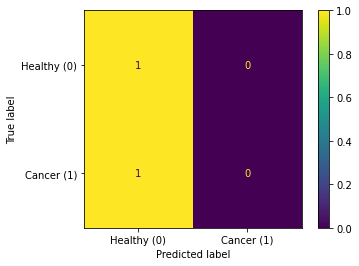

In [30]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [31]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.5002    1.0000    0.6669     16391
           1     0.0000    0.0000    0.0000     16377

    accuracy                         0.5002     32768
   macro avg     0.2501    0.5000    0.3334     32768
weighted avg     0.2502    0.5002    0.3336     32768



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


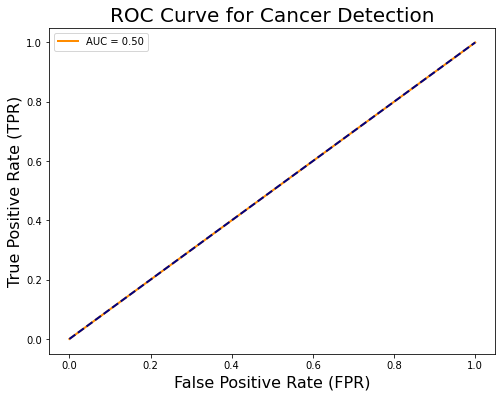

Area under curve (AUC):0.5
(2,)
(2,)


In [32]:
pcamlib.plot_roc_curve(y_true, y_proba)

1
4
5
6
8
9
10
14
17


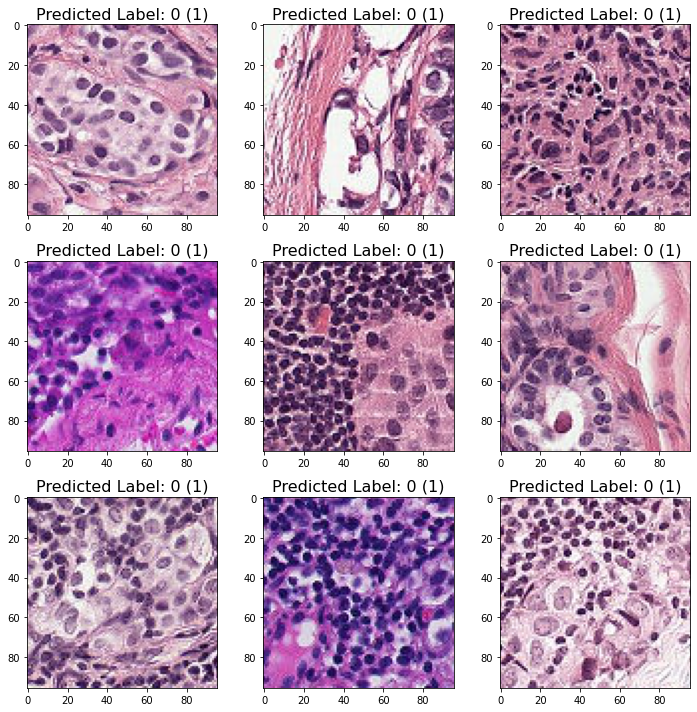

In [33]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)